In [69]:
import math
import pickle
import warnings
import torch
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from utils import *
from model import TranSiGen
from dataset import TranSiGenDataset

In [70]:
warnings.filterwarnings('ignore')

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Carregamento dos dados

Os dados são carregados a partir de um arquivo `.h5`:

In [73]:
data_path = '../data/LINCS2020/data_example/processed_data_id.h5'

In [74]:
data = load_from_HDF(data_path)

In [75]:
cell_count = len(set(data['cid']))
feat_type = 'KPGT'
batch_size = 64
learning_rate = 1e-3
beta = 0.1
dropout = 0.1
weight_decay = 1e-5
n_folds = 5
random_seed = 364039
split_type = 'smiles_split'
features_dim = 2304
features_embed_dim = [400]
n_latent = 100
# init_mode = 'pretrain_shRNA'
init_mode = 'random'
n_epochs = 300
molecule_path = '../data/LINCS2020/idx2smi.pickle'

In [76]:
local_out = './results/trained_models_{}_cell_{}/{}/feature_{}_init_{}/'.format(cell_count, split_type, random_seed, feat_type, init_mode)

In [77]:
with open(molecule_path, 'rb') as f:
    idx2smi = pickle.load(f)

## Divisão de treino e teste

In [78]:
pair, pairv, pairt = split_data(data, n_folds=n_folds, split_type=split_type, rnds=random_seed)

In [79]:
train = TranSiGenDataset(
    LINCS_index=pair['LINCS_index'],
    mol_feature_type=feat_type,
    mol_id=pair['canonical_smiles'],
    cid=pair['cid']
)

valid = TranSiGenDataset(
    LINCS_index=pairv['LINCS_index'],
    mol_feature_type=feat_type,
    mol_id=pairv['canonical_smiles'],
    cid=pairv['cid']
)

test = TranSiGenDataset(
    LINCS_index=pairt['LINCS_index'],
    mol_feature_type=feat_type,
    mol_id=pairt['canonical_smiles'],
    cid=pairt['cid']
)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_worker)
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_worker)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_worker)

## Criação do Modelo

In [89]:
pbounds = {
    'n_latent': (10, 600), # dimensão do espaço latente Z1, Z2
    'dropout': (0, 0.9),   # fator de dropout aplicado às redes de enc e dec
    'beta': (0, 1),        # hiperparâmetro beta que multiplica o termo KL na loss do VAE
    'features_embed_dim': (100, 1000) # dimensão do embedding da molécula dentro da rede
}

In [84]:
def train_model(n_latent, dropout, beta, features_embed_dim):
    model = TranSiGen(
        n_genes=978,
        n_latent=round(n_latent),
        n_en_hidden=[1200],
        n_de_hidden=[800],
        features_dim=features_dim,
        features_embed_dim=[round(features_embed_dim)],
        init_w=True,
        beta=beta,
        device=dev,
        dropout=dropout,
        path_model=f'./results/nl={round(n_latent)}-dp={dropout:.4f}-bt={beta:.4f}-fd={round(features_embed_dim)}--',
        random_seed=random_seed
    ).to(dev)
    
    epoch_hist, best_epoch = model.train_model(
        train_loader=train_loader,
        test_loader=valid_loader,
        n_epochs=300,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        save_model=True,
        verbose=False
    )
    
    return -epoch_hist['valid_loss'][best_epoch]

In [85]:
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    random_state=random_seed,
)

In [86]:
optimizer.maximize(init_points=0, n_iter=20)

|   iter    |  target   |   beta    |  dropout  | featur... | n_latent  |
-------------------------------------------------------------------------
| 1         | -2.82e+05 | 0.4762    | 0.4715    | 281.3     | 78.4      |
| 2         | -1.074e+0 | 0.3705    | 0.806     | 756.9     | 56.29     |
| 3         | -2.29e+05 | 0.1698    | 0.03348   | 131.0     | 35.97     |
| 4         | -4.868e+0 | 0.03253   | 0.07361   | 870.3     | 356.4     |
| 5         | -8.212e+0 | 0.9509    | 0.6447    | 408.1     | 112.0     |
| 6         | -1.736e+0 | 0.9184    | 0.2846    | 283.6     | 76.26     |
| 7         | -2.293e+0 | 0.98      | 0.1777    | 292.0     | 59.47     |
| 8         | -9.63e+04 | 0.6663    | 0.1592    | 856.1     | 342.7     |
| 9         | -6.173e+0 | 0.5744    | 0.7689    | 877.1     | 334.4     |
| 10        | -5.285e+0 | 0.8515    | 0.1548    | 898.6     | 352.8     |
| 11        | -1.33e+05 | 0.1172    | 0.4138    | 309.0     | 83.9      |
| 12        | -6.409e+0 | 0.4997    | 

In [88]:
optimizer.max

{'target': np.float64(-32867.381944444445),
 'params': {'beta': np.float64(0.8774366769532256),
  'dropout': np.float64(0.4757933942453553),
  'features_embed_dim': np.float64(861.456427889267),
  'n_latent': np.float64(389.6829646566845)}}

## Treinamento do Modelo

[Epoch 0] | loss: 9547.062, mse_x1_rec: 1184.497, mse_x2_rec: 6526.022, mse_pert: 1722.831, kld_x1: 540.982, kld_x2: 237.959, kld_pert: 358.173| valid_loss: 19468.241, valid_mse_x1_rec: 2536.467, valid_mse_x2_rec: 10269.840, valid_mse_pert: 6561.126, valid_kld_x1: 554.529, valid_kld_x2: 209.696, valid_kld_pert: 243.858|
[Epoch 1] | loss: 6198.265, mse_x1_rec: 727.863, mse_x2_rec: 4107.647, mse_pert: 1228.547, kld_x1: 615.953, kld_x2: 304.590, kld_pert: 421.532| valid_loss: 10890.234, valid_mse_x1_rec: 728.916, valid_mse_x2_rec: 6721.843, valid_mse_pert: 3322.238, valid_kld_x1: 616.975, valid_kld_x2: 241.538, valid_kld_pert: 313.845|
[Epoch 2] | loss: 3106.518, mse_x1_rec: 1169.733, mse_x2_rec: 1014.435, mse_pert: 741.277, kld_x1: 661.501, kld_x2: 467.828, kld_pert: 681.399| valid_loss: 4725.832, valid_mse_x1_rec: 2082.221, valid_mse_x2_rec: 1402.398, valid_mse_pert: 1073.426, valid_kld_x1: 729.651, valid_kld_x2: 372.003, valid_kld_pert: 576.216|
[Epoch 3] | loss: 6244.928, mse_x1_rec: 

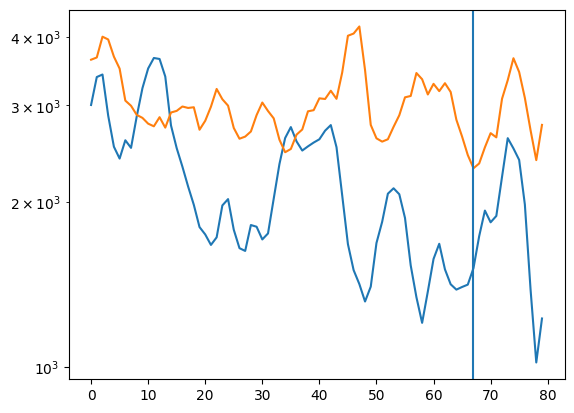

In [38]:
plt.plot(epoch_hist['train_loss'][20:])
plt.plot(epoch_hist['valid_loss'][20:])
plt.axvline(best_epoch - 20)
plt.yscale('log')

In [36]:
best_epoch

299

## Avaliação do Modelo no Conjunto Teste

In [39]:
_, _, test_metrics_dict_ls = model.test_model(loader=test_loader, metrics_func=['pearson'])

for name, rec_dict_value in zip(['test'], [test_metrics_dict_ls]):
    df_rec = pd.DataFrame.from_dict(rec_dict_value)
    smi_ls = []
    for smi_id in df_rec['cp_id']:
        smi_ls.append(idx2smi[smi_id])
    df_rec['canonical_smiles'] = smi_ls

In [40]:
df_rec

,x1_rec_pearson,x2_rec_pearson,x2_pred_pearson,DEG_rec_pearson,DEG_pred_pearson,cp_id,cid,sig,canonical_smiles
0,0.953311,0.943421,0.934272,0.530868,0.384587,9,MCF7,MCF7_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
1,0.979038,0.961746,0.939355,0.600370,0.516244,13,ASC,ASC_13,Brc1ccc(NC(=O)N2NC(=O)[C@H]([C@@H]2c2ccccc2)c2...
2,0.946736,0.937977,0.928489,0.192155,0.128870,6,A549,A549_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1
3,0.972693,0.953963,0.937324,0.441195,0.269208,9,PC3,PC3_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
4,0.857311,0.845146,0.833361,0.193010,0.181491,9,HT29,HT29_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
5,0.960250,0.951256,0.928602,0.392760,0.281274,9,HA1E,HA1E_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
6,0.945833,0.922042,0.895480,0.292409,0.254139,9,A549,A549_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
7,0.944911,0.942919,0.926531,0.228123,0.164221,6,A375,A375_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1
8,0.960405,0.953985,0.935398,0.350421,0.255856,6,HA1E,HA1E_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1
9,0.971232,0.967821,0.948738,0.278653,0.029422,6,PC3,PC3_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1


In [47]:
len(test_metrics_dict_ls['x1_rec_pearson'])

17

In [ ]:
}